## COVID 19 FORECASTING IN INDIA, ITALY, USA & BELGIUM

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import Holt
import datetime
import pickle

In [104]:
def model_logistic(t,a,b,c):
    return c/(1 + a*np.exp(-b*t))

In [105]:
def make_train_test(data,string,ratio):
    
    x = list(data.index)
    y = list(data[string])
    n = len(data)
    if ratio<1:
        x_train = x[:int(ratio*n)]
        y_train = y[:int(ratio*n)]
        x_test = x[int(ratio*n):]
        y_test = y[int(ratio*n):]
        return x_train,y_train,x_test,y_test
    else:
        return x,y


In [106]:
def get_model_confirmed_logistic(x_train,y_train,x_test,y_test,p0,c_upper,b_upper):
    a_list = list(np.arange(10000,c_upper - 1,10000))
    min_rmse = 9999999
    min_k = 0
    rmse_plot = []
    for k in  a_list:
        bounds = [0, [k,b_upper,c_upper]]
        
        (a,b,c),mod = optim.curve_fit(model_logistic,x_train,y_train,bounds=bounds,p0=p0)
        y_pred = [model_logistic(i,a,b,c) for i in x_test]
        rmse = np.sqrt(mean_squared_error(y_pred,y_test))
        if rmse<min_rmse:
            min_rmse = rmse
            min_k = k
            min_a = a
            min_b = b
            min_c = c
        
        rmse_plot.append(rmse)
    #print("rmse=",rmse_plot)
    return min_rmse,min_k,min_a,min_b,min_c,rmse_plot

In [107]:
def get_model_holt(y_train,y_test):
    min_rmse = 999999
    min_idx = 0
    best_fit=-1
    rmse_plot = []
    alpha_list = list(np.arange(0,1,0.05))
    beta_list = list(np.arange(0,1,0.05))
    for beta in beta_list: 
        for alpha in alpha_list:

            holt_fit = Holt(np.asarray(y_train)).fit(smoothing_level=alpha,smoothing_slope=beta)
            y_pred = holt_fit.forecast(len(y_test))
            rmse = np.sqrt(mean_squared_error(y_pred,y_test))
            #print("For alpha = "+str(alpha)+"beta = "+str(beta)+", RMSE = "+str(rmse))
            rmse_plot.append(rmse)
            if rmse<min_rmse:
                rmse=min_rmse
                best_fit = holt_fit
                best_alpha = alpha
                best_beta = beta
    print("best alpha =",alpha)
    print("best beta = ",beta)
    #plt.plot(alpha_list,rmse_plot)
    return best_fit      

In [108]:
def run_logistic_growth(data,string,ratio):
    x_train,y_train,x_test,y_test = make_train_test(data,string,ratio)
    x = x_train+x_test
    y = y_train+y_test
    flag=0
    while(flag==0):
        try : 
            p0 = np.random.exponential(size=3)
            if string!="Confirmed":
                c_upper=2000000
            else:
                c_upper = 10000000
            rmse,k,a,b,c,rmse_plot = get_model_confirmed_logistic(x_train,y_train,x_test,y_test,p0,c_upper,3)
            flag=1
        except:
            pass
    return rmse,k,a,b,c,p0,rmse_plot
        
def run_holt(data,string,ratio):
    x_train,y_train,x_test,y_test = make_train_test(data,string,ratio)
    x = x_train+x_test
    y = y_train+y_test
    
    
    y_train = [np.double(i) for i in y_train]
    holt_fit = get_model_holt(y_train,y_test)
    return holt_fit
def plot_holt(model,data,string,ratio):
    x_train,y_train,x_test,y_test = make_train_test(data,string,ratio)
    x = x_train+x_test
    y = y_train+y_test
    y_pred_holt = model.forecast(len(y_test))
    print(y_pred_holt)
    print(model.forecast(len(y_test)+7))
    plt.figure(figsize=(10,10))
    plt.title(str(string)+" cases")
    plt.scatter(x,y,color='blue')
    plt.scatter(x_test,y_pred_holt,color='red')
    print("RMSE = ",np.sqrt(mean_squared_error(y_test,y_pred_holt)))
    print("Average Percentage error (in %) = ",mean_percentage_error(y_test,y_pred_holt))

def plot_logistic(a,b,c,data,string,ratio):
    x_train,y_train,x_test,y_test = make_train_test(data,string,ratio)
    x = x_train+x_test
    y = y_train+y_test
    y_pred = [model_logistic(i,a,b,c) for i in x_test]
    plt.figure(figsize=(10,10))
    plt.title(string)
    plt.scatter(x_train+x_test,y_train+y_test)
    plt.scatter(x_test,y_pred,color='red')
    plt.show()
    print("RMSE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
    print("Average Percentage error (in %) = ",mean_percentage_error(y_test,y_pred))

def dump_pickle(obj,name):
    file = open(name+str('.pkl'), 'wb')
    pickle.dump(obj, file)
def load_pickle(pkl_name):
    readfile = open(pkl_name, 'rb')
    model = pickle.load(readfile)
    return model


In [109]:
def give_full_logistic(x,y,bounds,p0):
    (a,b,c),mod = optim.curve_fit(model_logistic,x,y,bounds=bounds,p0=p0)
    return a,b,c,p0

In [110]:
def give_full_holt(y,a,b):
    alpha=a
    beta=b
    y = [np.double(i) for i in y]
    holt_fit = Holt(np.asarray(y)).fit(smoothing_level=alpha,smoothing_slope=beta)
    return holt_fit

In [198]:
def predict(start_date,end_date,country,model_cnf,model_rec,model_dea,data,output_path):
    sd = [int(i) for i in start_date.split("-")]
    s_date = datetime.date(sd[0],sd[1],sd[2])
    ed = [int(i) for i in end_date.split("-")]
    e_date = datetime.date(ed[0],ed[1],ed[2])
    
    
    train_ed = data.tail(1)['Date'].item()
    train_idx = data.tail(1).index.item()
    train_ed = [int(i) for i in train_ed.split("-")]
    train_edate = datetime.date(train_ed[0],train_ed[1],train_ed[2])
    e_init_diff = (e_date - train_edate).days
    diff = (e_date - s_date).days
    date_seq = [(s_date + datetime.timedelta(days=i)).strftime("%Y-%m-%d") for i in range(diff+1)]
    from_train_idx_date_seq = [(train_edate + datetime.timedelta(days=i)).strftime("%Y-%m-%d") for i in range(1,e_init_diff+1)]
    #print(date_seq)
    #print(from_train_idx_date_seq)
    flag="0"
    data_dates = data['Date'].to_list()
    last_date = start_date
    pred_cnf = []
    pred_rec = []
    pred_dea = []


    while flag=="0":
        for i in date_seq:
            if i in data_dates:
                pred_cnf.append(data.loc[data['Date']==i]['Confirmed'].item())
                pred_rec.append(data.loc[data['Date']==i]['Recovered'].item())
                pred_dea.append(data.loc[data['Date']==i]['Deaths'].item())
                flag+="1"
            else:
                last_date = i
                flag+="2"
                break


    #print(flag)
    #print(pred_cnf)

    if "2" not in flag:
        pass
    else:
        #print(last_date)
        t = list(np.arange( train_idx+1 , train_idx+e_init_diff+1 ,1))
        #print(t)
        cnf_forecast = list(model_cnf.forecast(len(t))[0])
        rec_forecast = list(model_rec.forecast(len(t))[0])
        dea_forecast = list(model_dea.forecast(len(t))[0])
        #print(cnf_forecast)
        forecast_start_index = from_train_idx_date_seq.index(last_date)
        #print(forecast_start_index)
        #print(cnf_forecast[forecast_start_index:])
        pred_cnf.extend(cnf_forecast[forecast_start_index: ])
        pred_rec.extend(rec_forecast[forecast_start_index:])
        pred_dea.extend(dea_forecast[forecast_start_index:])

    df_dict = {'Date':date_seq,'Confirmed':pred_cnf,"Recovered":pred_rec,"Deaths":pred_dea}
    
    df = pd.DataFrame(df_dict)
    print(df)
    df.to_csv(str(output_path)+str(country)+".preds",sep='\t',index=False,header=None)

In [112]:
def mean_percentage_error(true,pred):
    s = 0
    for i in range(len(true)):
        s+= (abs(true[i]-pred[i])/true[i])*100
    return s/len(true)

In [113]:
def do_shit(country,string,data):
    x,y = make_train_test(data,string,1)
    model = give_full_holt(y,0.95,0.95)
    print(model.forecast(7))
    
    dump_pickle(model,"model_"+str(country)+"_"+str(string))

In [134]:
def do_shit_arima(country,string,data,a,b,c):
    #x,y = make_train_test(data,string,1)
    model = ARIMA(data[string], order=(a,b,c))
    model_fit = model.fit(disp=0)
    dump_pickle(model_fit,"model_arima_"+str(country)+"_"+str(string))

In [191]:
def give_full_arima(string,data,a,b,c):
    ratio=0.96
    x_train,y_train,x_test,y_test = make_train_test(data,string,ratio)
    x = x_train+x_test
    y = y_train+y_test
    
    model = ARIMA(y_train, order=(a,b,c))
    model_fit = model.fit(disp=0)
    return model_fit

In [137]:
def tune_arima(string,data):
    _,y_train,_,y_test = make_train_test(data,string,0.96)
    min_rmse = 999900
    for a in range(5,1,-1):
        for b in range(1,5):
            for c in range(5):
                try:
                    model = ARIMA(y_train, order=(a,b,c))
                    model_fit = model.fit(disp=0)
                    preds = list(model_fit.forecast(len(y_test))[0])
                    true = list(y_test)
                    #print(preds)
                    #print(true)
                    rmse = np.sqrt(mean_squared_error(preds,true))
                    if rmse<min_rmse:
                        min_rmse = rmse
                        min_a = a
                        min_b = b
                        min_c = c
                except:
                    pass
                    #print("error for ",a,b,c)
    return min_rmse,min_a,min_b,min_c
                

In [358]:
def plot_arima(model,data,string,ratio,fore):
    if fore==False:
        x_train,y_train,x_test,y_test = make_train_test(data,string,ratio)
        x = x_train+x_test
        y = y_train+y_test
        y_pred_holt = list(model.forecast(len(y_test))[0])
    else:
        x,y = make_train_test(data,string,1)
        x_fore = list(np.arange(x[-1]+1,x[-1]+8))
        print(x_fore)
        y_fore = list(model.forecast(len(x_fore))[0])
    #print(y_pred_holt)
    #print(model.forecast(len(y_test)+7))
    
    plt.figure(figsize=(10,10))
    plt.title(str(string)+" cases")
    plt.plot(x,y,color='blue',label='Observed Cases')
    if fore:
        plt.scatter(x_fore,y_fore,color='green',label='Forecast for next 7 days')                 
    elif fore==False:
        plt.scatter(x_test,y_pred_holt,color='red',label='Predicted Cases for observed values')
    plt.legend(loc="upper left")
    plt.grid(b=True, which='major', color='#666666', linestyle='-')

# Show the minor grid lines with very faint and almost transparent grey lines
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    if fore==False:
        print("RMSE = ",np.sqrt(mean_squared_error(y_test,y_pred_holt)))
        print("Average Percentage error (in %) = ",mean_percentage_error(y_test,y_pred_holt))

## 1) Holt Linear Method

## India

In [59]:
data_india = pd.read_csv("./data/India.csv",sep='\t')

In [15]:
data_india.tail(1)['Date'].index.item()

90

In [16]:
model_india = run_holt(data_india,"Confirmed",0.95)

/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


best alpha = 0.9500000000000001
best beta =  0.9500000000000001


[26029.99849063 27520.40092566 29010.80336069 30501.20579572
 31991.60823076]
[26029.99849063 27520.40092566 29010.80336069 30501.20579572
 31991.60823076 33482.01066579 34972.41310082]
RMSE =  665.9001671440847
Average Percentage error (in %) =  1.9293465673852637


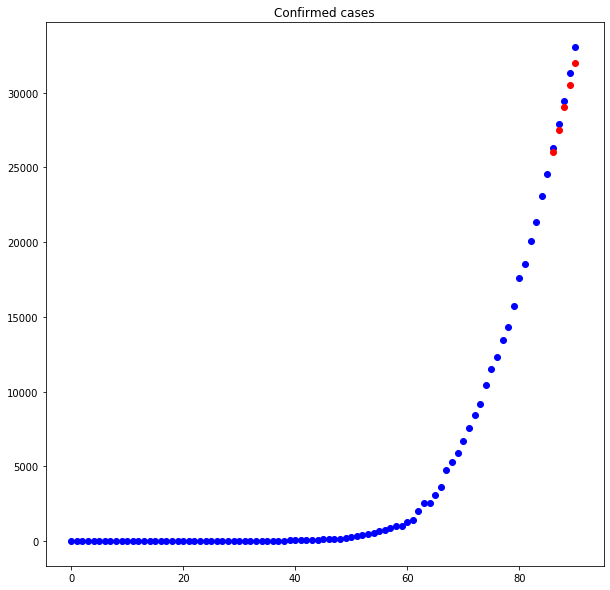

In [17]:
plot_holt(model_india,data_india,"Confirmed",0.95)

In [16]:
model_india_rec = run_holt(data_india,"Recovered",0.95)


/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


best alpha = 0.9500000000000001
best beta =  0.9500000000000001


RMSE =  211.65121314602092
Average Percentage error (in %) =  2.0788082255889333


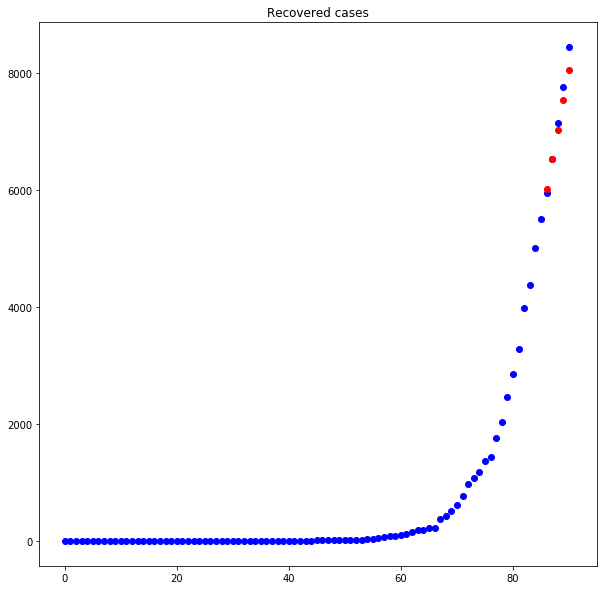

In [17]:
plot_holt(model_india_rec,data_india,"Recovered",0.95)

In [18]:
model_india_dea = run_holt(data_india,"Deaths",0.95)

/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


best alpha = 0.9500000000000001
best beta =  0.9500000000000001


RMSE =  11.05001213192919
Average Percentage error (in %) =  1.0670797931030132


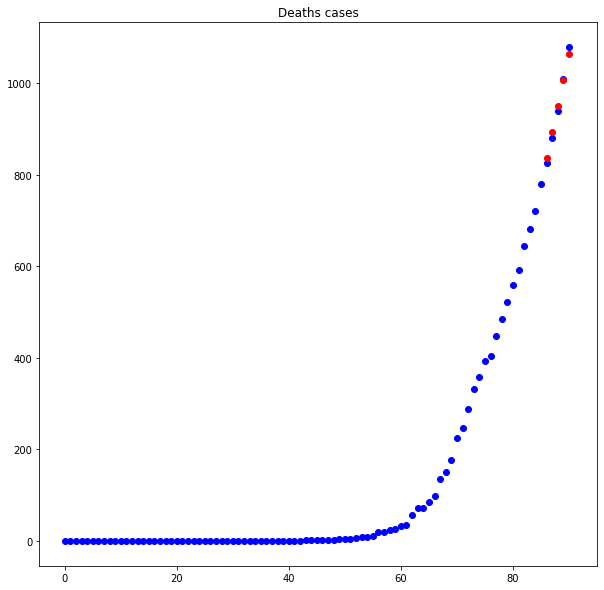

In [19]:
plot_holt(model_india_dea,data_india,"Deaths",0.95)

## Italy

In [58]:
data_italy = pd.read_csv("./data/Italy.csv",sep='\t')

In [29]:
model_italy_cnf = run_holt(data_italy,"Confirmed",0.97)

/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:7

best alpha = 0.9500000000000001
best beta =  0.9500000000000001


[199988.83173084 202296.00462888 204603.17752692]
[199988.83173084 202296.00462888 204603.17752692 206910.35042496
 209217.523323   211524.69622104 213831.86911908 216139.04201712
 218446.21491516 220753.3878132 ]
RMSE =  812.5316789080064
Average Percentage error (in %) =  0.3926570240957039


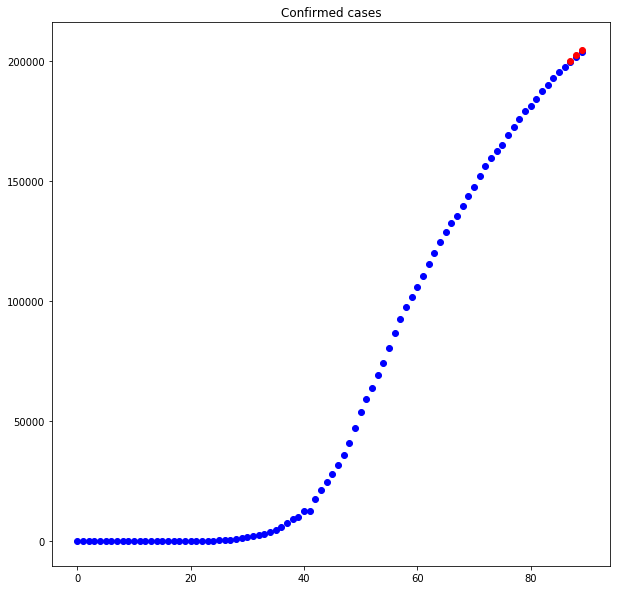

In [30]:
plot_holt(model_italy_cnf,data_italy,"Confirmed",0.97)

In [31]:
model_italy_rec = run_holt(data_italy,"Recovered",0.95)

best alpha = 0.9500000000000001
best beta =  0.9500000000000001


[63441.88409168 66380.05148824 69318.2188848 ]
[63441.88409168 66380.05148824 69318.2188848  72256.38628136
 75194.55367793 78132.72107449 81070.88847105 84009.05586761
 86947.22326418 89885.39066074]
RMSE =  2609.203475864927
Average Percentage error (in %) =  3.734976380732886


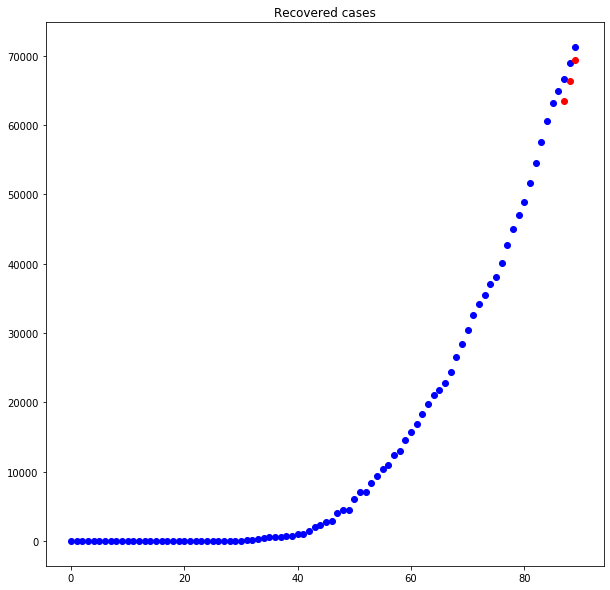

In [32]:
plot_holt(model_italy_rec,data_italy,"Recovered",0.97)

In [33]:
model_italy_dea = run_holt(data_italy,"Deaths",0.95)

/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


best alpha = 0.9500000000000001
best beta =  0.9500000000000001


[26395.14878183 26819.38544599 27243.62211015 27667.85877431
 28092.09543847]
[26395.14878183 26819.38544599 27243.62211015 27667.85877431
 28092.09543847 28516.33210262 28940.56876678 29364.80543094
 29789.0420951  30213.27875926 30637.51542342 31061.75208758]
RMSE =  270.38628320880844
Average Percentage error (in %) =  0.8598409331503832


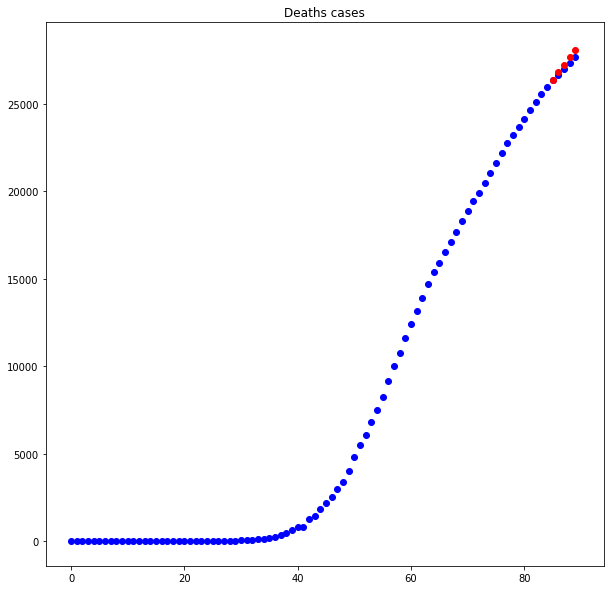

In [42]:
plot_holt(model_italy_dea,data_italy,"Deaths",0.95)

### USA

In [57]:
data_us = pd.read_csv("./data/US.csv",sep='\t')

/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


best alpha = 0.9500000000000001
best beta =  0.9500000000000001
RMSE =  7500.577690424215
Average Percentage error (in %) =  0.6083654777238419


/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


best alpha = 0.9500000000000001
best beta =  0.9500000000000001
RMSE =  2263.1530914676496
Average Percentage error (in %) =  1.8015661818119202


/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


best alpha = 0.9500000000000001
best beta =  0.9500000000000001
RMSE =  466.719029343553
Average Percentage error (in %) =  0.7789495372049695


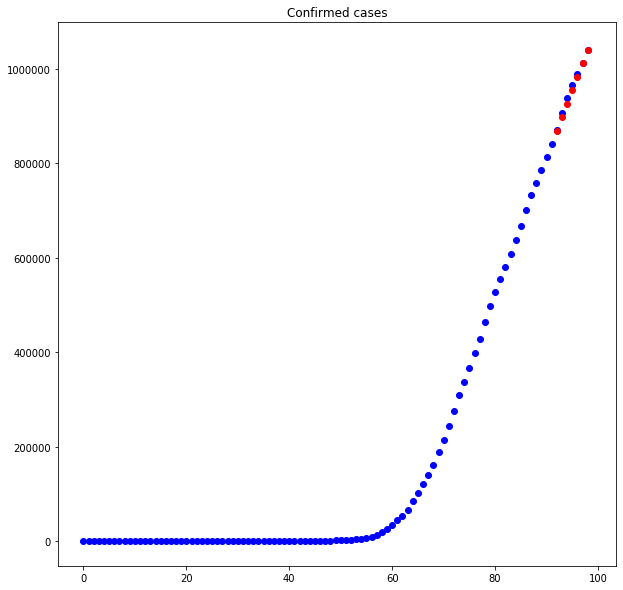

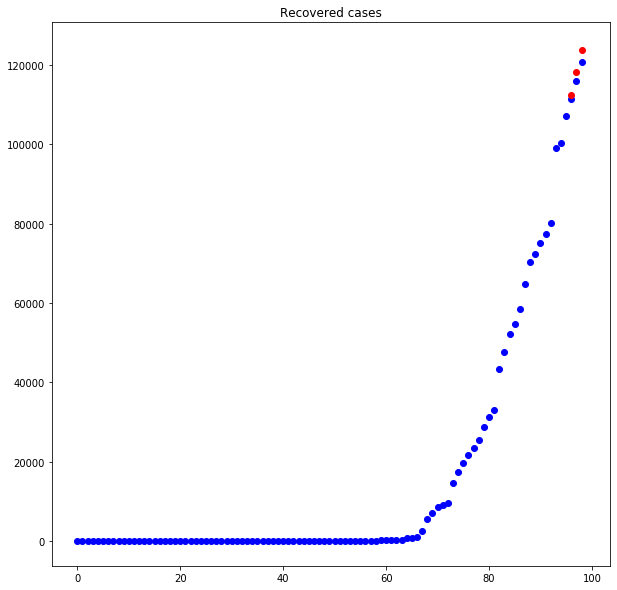

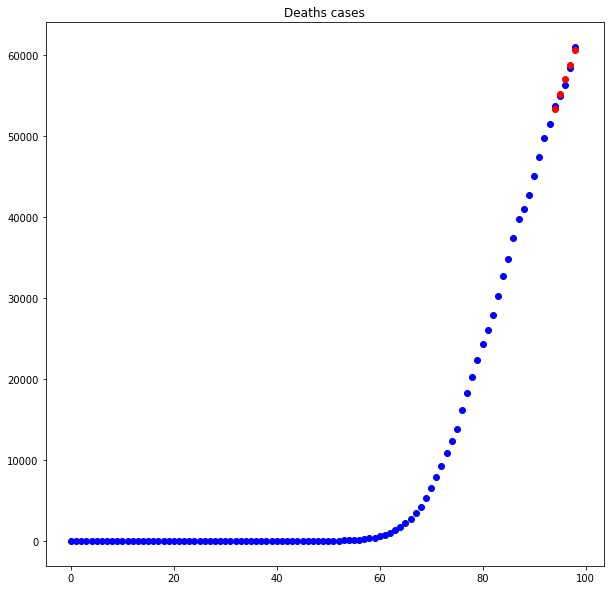

In [26]:
model_us_cnf = run_holt(data_us,"Confirmed",0.93)
plot_holt(model_us_cnf,data_us,"Confirmed",0.93)
model_us_rec = run_holt(data_us,"Recovered",0.97)
plot_holt(model_us_rec,data_us,"Recovered",0.97)
model_us_dea = run_holt(data_us,"Deaths",0.95)
plot_holt(model_us_dea,data_us,"Deaths",0.95)


### Belgium

In [56]:
data_bel = pd.read_csv("./data/Belgium.csv",sep='\t')

/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


best alpha = 0.9500000000000001
best beta =  0.9500000000000001
RMSE =  437.60505819306104
Average Percentage error (in %) =  0.7954173664689305


/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


best alpha = 0.9500000000000001
best beta =  0.9500000000000001
RMSE =  251.8469631511554
Average Percentage error (in %) =  1.9954064934881517
best alpha = 0.9500000000000001
best beta =  0.9500000000000001
RMSE =  89.72037582204668
Average Percentage error (in %) =  1.0562095895459547


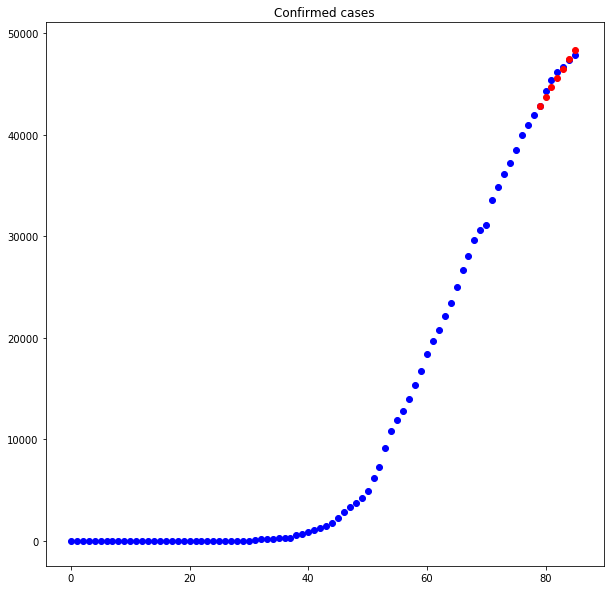

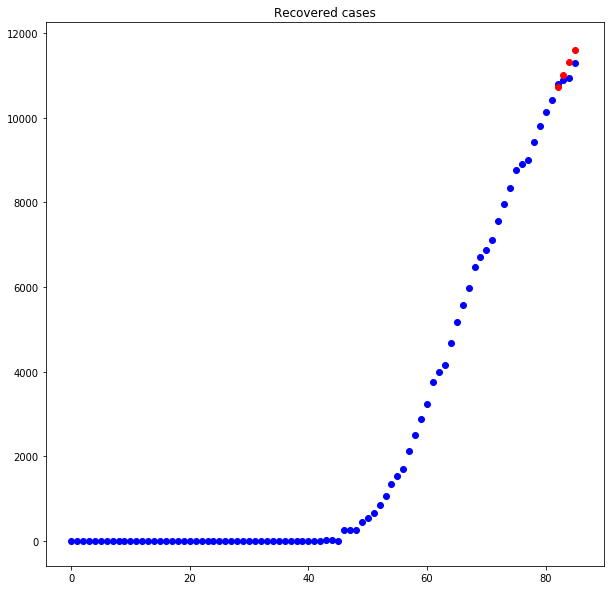

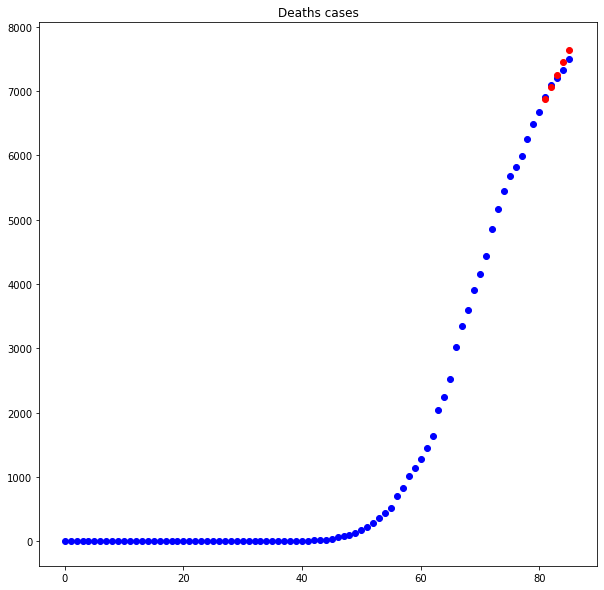

In [29]:
model_bel_cnf = run_holt(data_bel,"Confirmed",0.93)
plot_holt(model_bel_cnf,data_bel,"Confirmed",0.93)
model_bel_rec = run_holt(data_bel,"Recovered",0.96)
plot_holt(model_bel_rec,data_bel,"Recovered",0.96)
model_bel_dea = run_holt(data_bel,"Deaths",0.95)
plot_holt(model_bel_dea,data_bel,"Deaths",0.95)


## Holt not performing so good!

## 2) ARIMA Forecasting

In [1]:
from statsmodels.tsa.arima_model import ARIMA

#### Tune ARIMA gives best p,d,q for ARIMA models

In [ ]:
# tune_arima('Confirmed',data_india)

# tune_arima('Recovered',data_india)

# tune_arima('Deaths',data_india)

# tune_arima('Confirmed',data_us)

# tune_arima('Recovered',data_us)

# tune_arima('Deaths',data_us)

# tune_arima('Confirmed',data_italy)

# tune_arima('Recovered',data_italy)

# tune_arima('Deaths',data_italy)

# tune_arima('Confirmed',data_bel)

# tune_arima('Recovered',data_bel)

# tune_arima('Deaths',data_bel)

### India

RMSE =  79.99090193945202
Average Percentage error (in %) =  0.2340530532906121


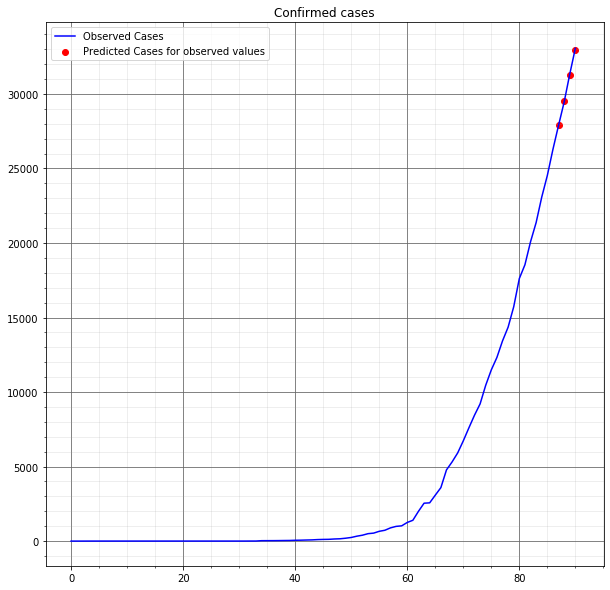

In [359]:
model_cnf = give_full_arima('Confirmed',data_india,5,2,0)
plot_arima(model_cnf,data_india,'Confirmed',0.96,False)

/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


RMSE =  247.73012627671832
Average Percentage error (in %) =  2.7076164029025804


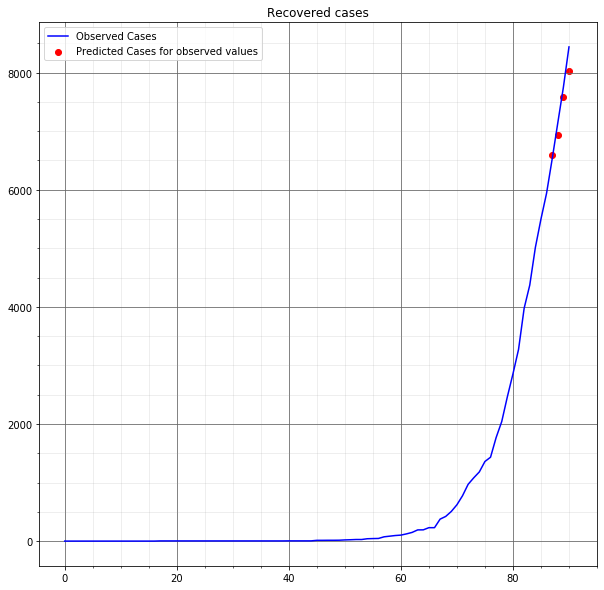

In [360]:
model_rec = give_full_arima('Recovered',data_india,5,2,0)
plot_arima(model_rec,data_india,'Recovered',0.96,False)

RMSE =  23.358309733385468
Average Percentage error (in %) =  1.730870995044023


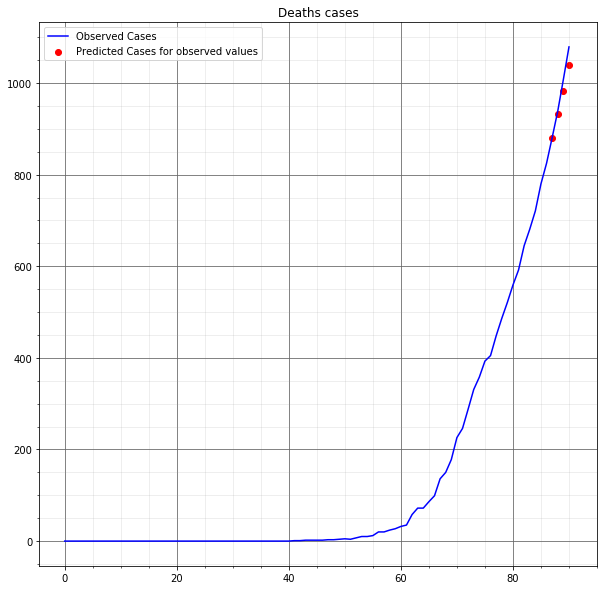

In [361]:
model_dea_ind_train = give_full_arima('Deaths',data_india,2,2,1)
plot_arima(model_dea_ind_train,data_india,'Deaths',0.96,False)

In [362]:
#save models

In [363]:
do_shit_arima('india','Confirmed',data_india,5,2,0)
do_shit_arima('india','Recovered',data_india,5,2,0)
do_shit_arima('india','Deaths',data_india,2,2,1)

In [364]:
model_india_cnf_arima = load_pickle('model_arima_india_Confirmed.pkl')
model_india_rec_arima = load_pickle('model_arima_india_Recovered.pkl')
model_india_dea_arima = load_pickle('model_arima_india_Deaths.pkl')

### forecasting : India

In [365]:
predict("2020-04-30","2020-05-07","India",model_india_cnf_arima,model_india_rec_arima,model_india_dea_arima,data_india,'./test_op/')

         Date     Confirmed     Recovered       Deaths
0  2020-04-30  34876.921219   9080.866314  1144.559756
1  2020-05-01  36620.997641   9776.454077  1218.424487
2  2020-05-02  38439.044994  10467.364391  1287.275389
3  2020-05-03  40321.036550  11158.053847  1359.420128
4  2020-05-04  42163.363068  11879.389996  1433.014994
5  2020-05-05  44051.643545  12583.516854  1504.704122
6  2020-05-06  45933.409976  13314.415654  1580.314252
7  2020-05-07  47867.515026  14044.127166  1654.341421


[91, 92, 93, 94, 95, 96, 97]


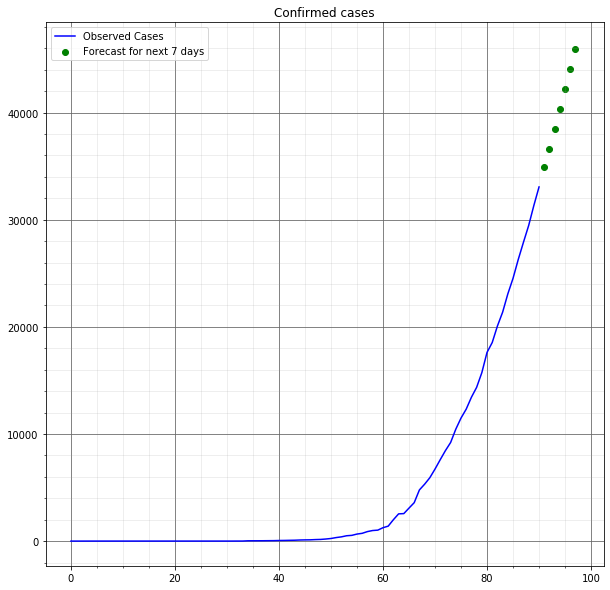

In [366]:
plot_arima(model_india_cnf_arima,data_india,'Confirmed',1,True)

[91, 92, 93, 94, 95, 96, 97]


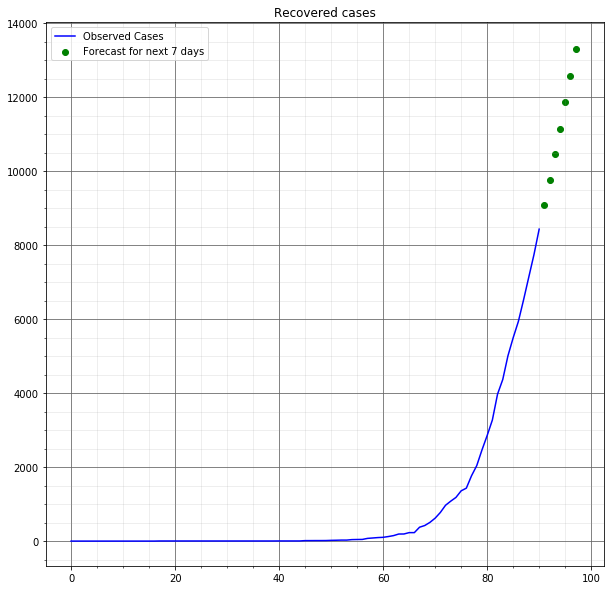

In [367]:
plot_arima(model_india_rec_arima,data_india,'Recovered',1,True)

[91, 92, 93, 94, 95, 96, 97]


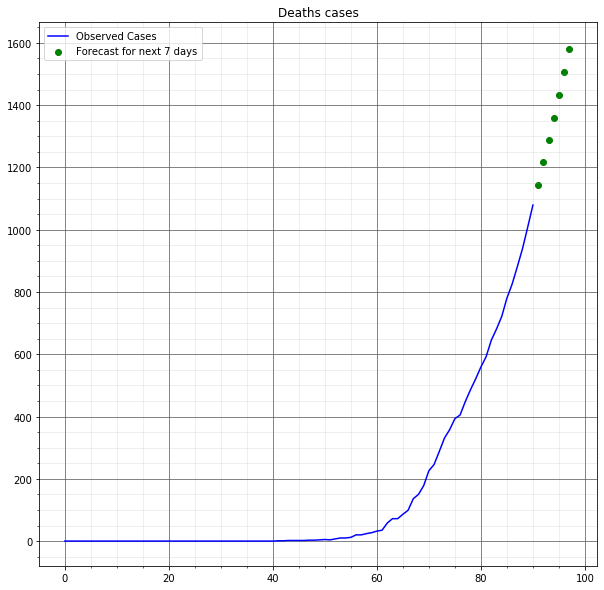

In [368]:
plot_arima(model_india_dea_arima,data_india,'Deaths',1,True)

### US

RMSE =  20879.81898564481
Average Percentage error (in %) =  1.869782774067258


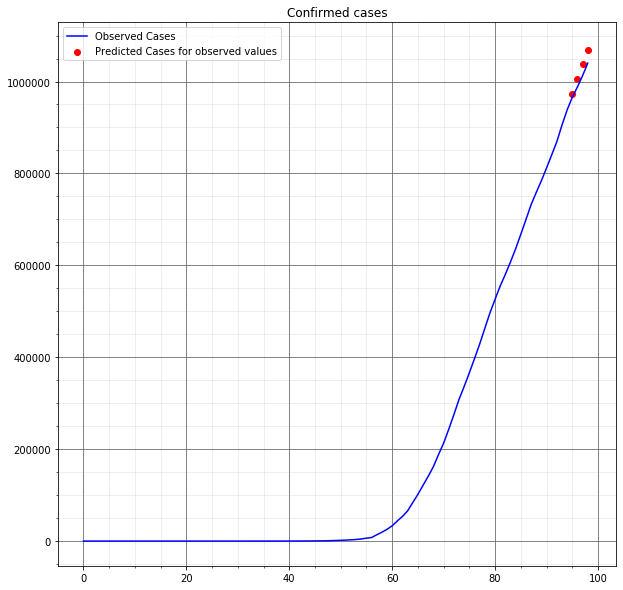

In [369]:
model_cnf = give_full_arima('Confirmed',data_us,2,1,3)
plot_arima(model_cnf,data_us,'Confirmed',0.96,False)

RMSE =  3730.421101213065
Average Percentage error (in %) =  3.2064213954261933


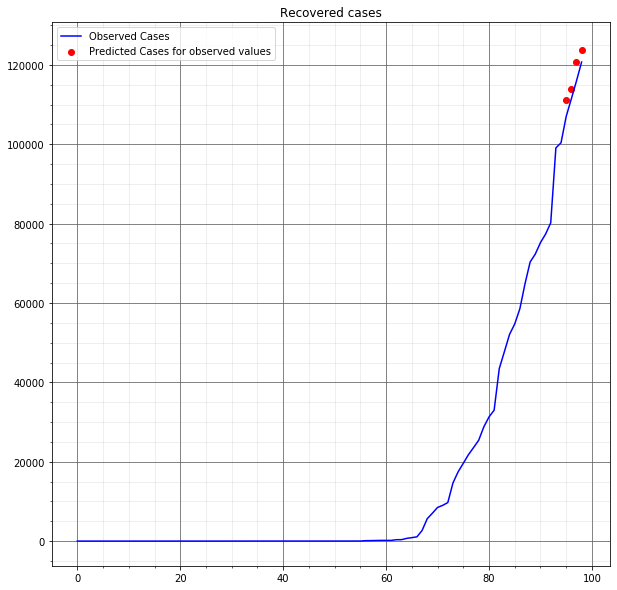

In [370]:
model_rec = give_full_arima('Recovered',data_us,2,1,0)
plot_arima(model_rec,data_us,'Recovered',0.96,False)

RMSE =  1519.0533933656282
Average Percentage error (in %) =  2.571953482263066


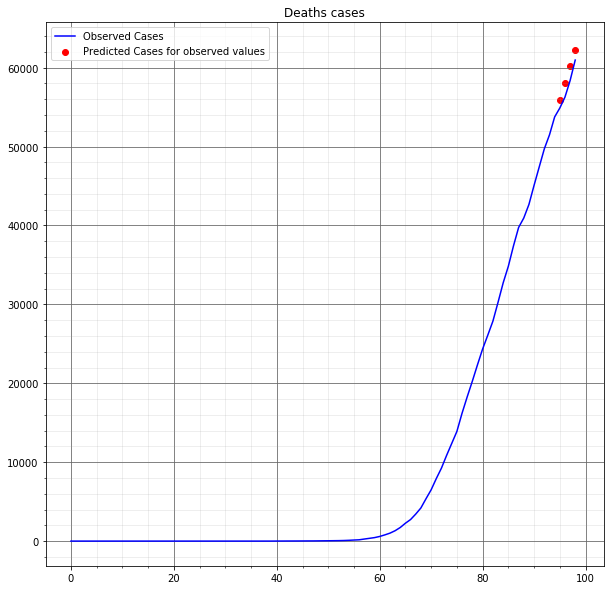

In [371]:
model_dea = give_full_arima('Deaths',data_us,2,1,0)
plot_arima(model_dea,data_us,'Deaths',0.96,False)

### Forcasting USA

In [372]:
do_shit_arima('us','Confirmed',data_us,2,1,3)
do_shit_arima('us','Recovered',data_us,2,1,1)
do_shit_arima('us','Deaths',data_us,2,1,0)

In [373]:
model_us_cnf_arima = load_pickle('model_arima_us_Confirmed.pkl')
model_us_rec_arima = load_pickle('model_arima_us_Recovered.pkl')
model_us_dea_arima = load_pickle('model_arima_us_Deaths.pkl')

In [374]:
predict("2020-04-30","2020-05-07","us",model_us_cnf_arima,model_us_rec_arima,model_us_dea_arima,data_us,'./test_op/')

         Date     Confirmed      Recovered        Deaths
0  2020-04-30  1.067717e+06  125779.703907  63459.463436
1  2020-05-01  1.094958e+06  130746.462924  65928.115000
2  2020-05-02  1.121803e+06  135696.143425  68359.634823
3  2020-05-03  1.148569e+06  140613.588509  70756.938526
4  2020-05-04  1.175133e+06  145502.275329  73120.499965
5  2020-05-05  1.201546e+06  150361.861606  75451.136267
6  2020-05-06  1.227789e+06  155192.783267  77749.593092
7  2020-05-07  1.253874e+06  159995.313065  80016.606928


[99, 100, 101, 102, 103, 104, 105]


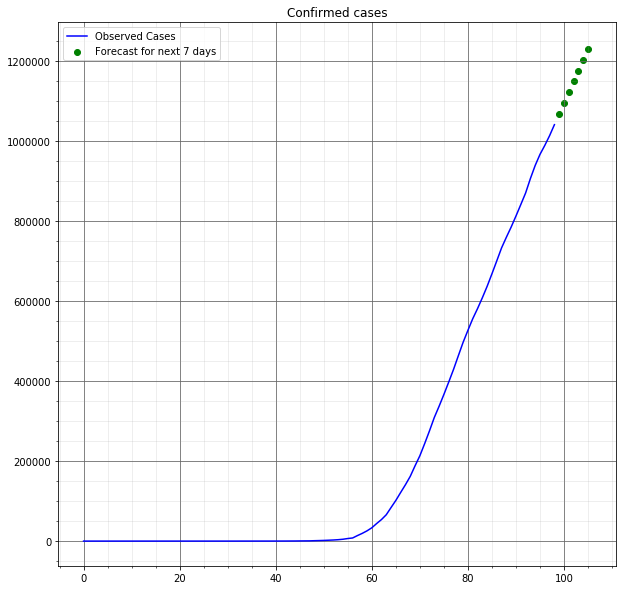

In [375]:
plot_arima(model_us_cnf_arima,data_us,'Confirmed',1,True)

[99, 100, 101, 102, 103, 104, 105]


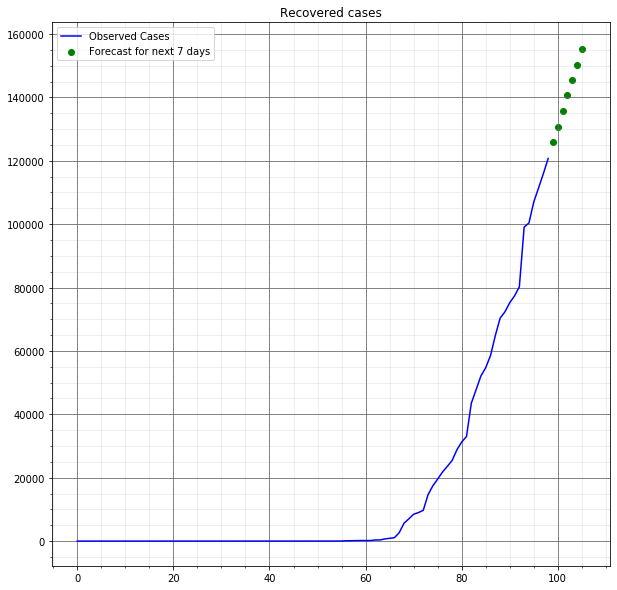

In [376]:
plot_arima(model_us_rec_arima,data_us,'Recovered',1,True)

[99, 100, 101, 102, 103, 104, 105]


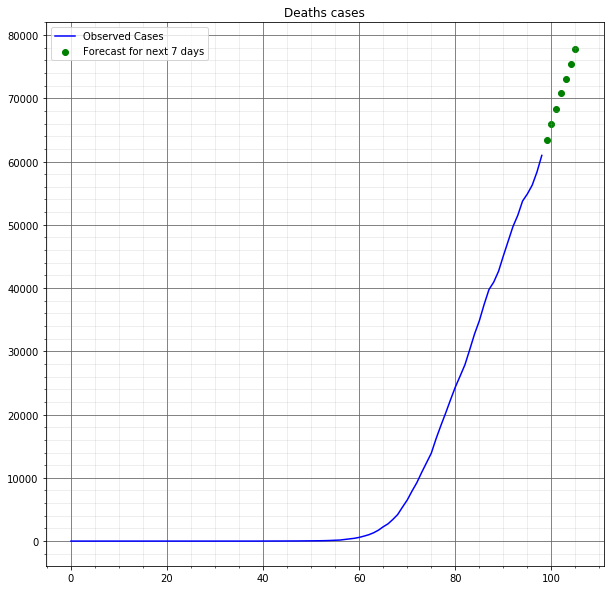

In [377]:
plot_arima(model_us_dea_arima,data_us,'Deaths',1,True)

### Belgium

/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/as

RMSE =  944.8993807954315
Average Percentage error (in %) =  1.7677506426012668


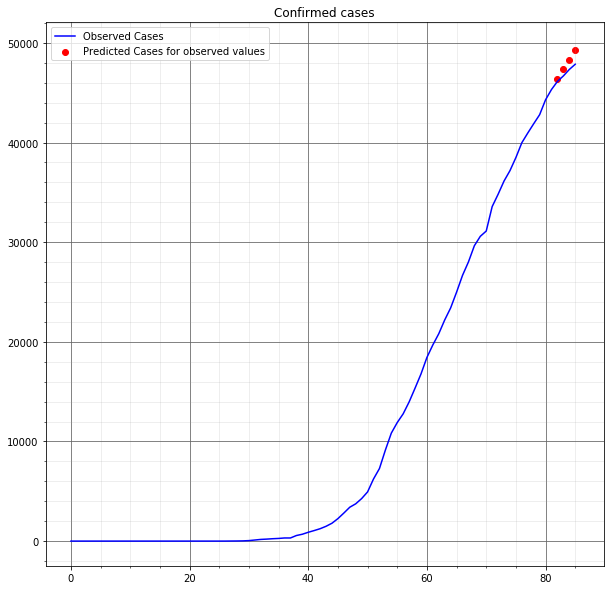

In [378]:
model_cnf = give_full_arima('Confirmed',data_bel,5,1,3)
plot_arima(model_cnf,data_bel,'Confirmed',0.96,False)

/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/as

RMSE =  29.817057001620935
Average Percentage error (in %) =  0.1961177272121707


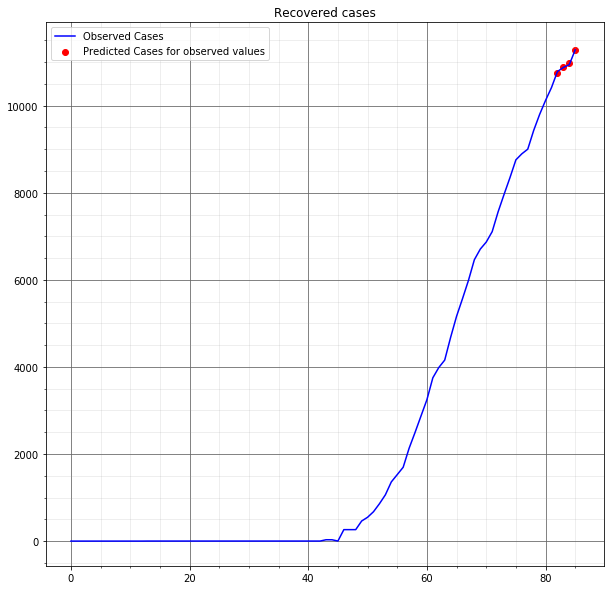

In [379]:
model_rec = give_full_arima('Recovered',data_bel,5,2,2)
plot_arima(model_rec,data_bel,'Recovered',0.96,False)

RMSE =  167.28050640935277
Average Percentage error (in %) =  1.985532586946027


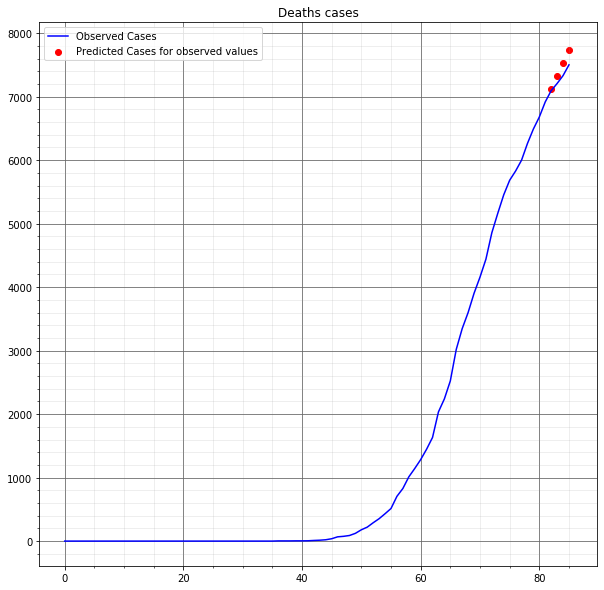

In [380]:
model_dea = give_full_arima('Deaths',data_bel,4,1,3)
plot_arima(model_dea,data_bel,'Deaths',0.96,False)

In [381]:
do_shit_arima('belgium','Confirmed',data_bel,5,1,3)
do_shit_arima('belgium','Recovered',data_bel,5,2,2)
do_shit_arima('belgium','Deaths',data_bel,4,1,3)

/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/as

In [382]:
model_belgium_cnf_arima = load_pickle('model_arima_belgium_Confirmed.pkl')
model_belgium_rec_arima = load_pickle('model_arima_belgium_Recovered.pkl')
model_belgium_dea_arima = load_pickle('model_arima_belgium_Deaths.pkl')

In [383]:
predict("2020-04-30","2020-05-07","belgium",model_belgium_cnf_arima,model_belgium_rec_arima,model_belgium_dea_arima,data_bel,'./test_op/')

         Date     Confirmed     Recovered       Deaths
0  2020-04-30  48584.393529  11692.877313  7635.142731
1  2020-05-01  49318.806920  12015.380981  7780.849325
2  2020-05-02  49916.911522  12340.775902  7936.518792
3  2020-05-03  50469.658129  12615.185277  8069.383482
4  2020-05-04  50928.888298  12740.143097  8207.912878
5  2020-05-05  51449.661767  12888.116729  8354.013384
6  2020-05-06  52000.567659  13226.161536  8484.978062
7  2020-05-07  52613.249478  13646.034909  8617.965651


[86, 87, 88, 89, 90, 91, 92]


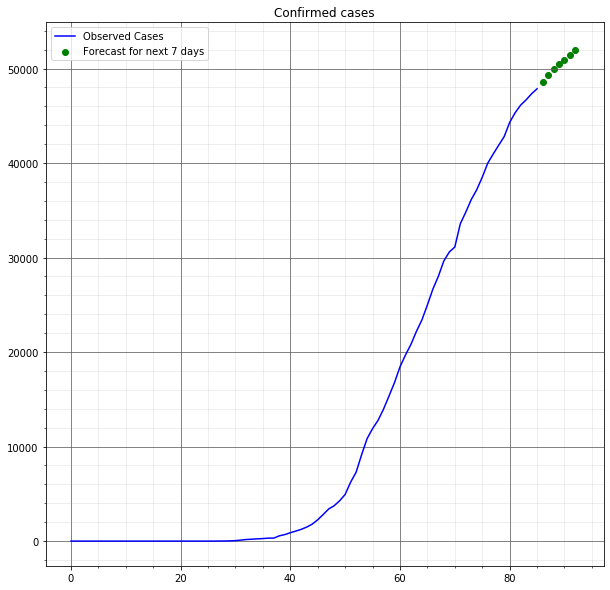

In [384]:
plot_arima(model_belgium_cnf_arima,data_bel,'Confirmed',1,True)

[86, 87, 88, 89, 90, 91, 92]


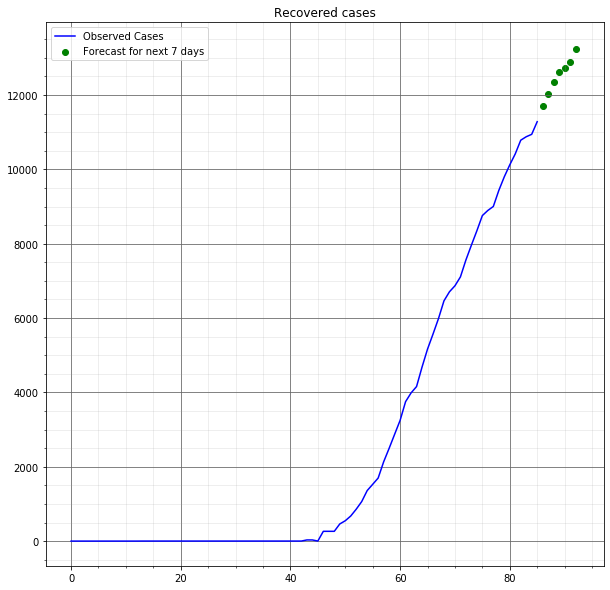

In [385]:
plot_arima(model_belgium_rec_arima,data_bel,'Recovered',1,True)

[86, 87, 88, 89, 90, 91, 92]


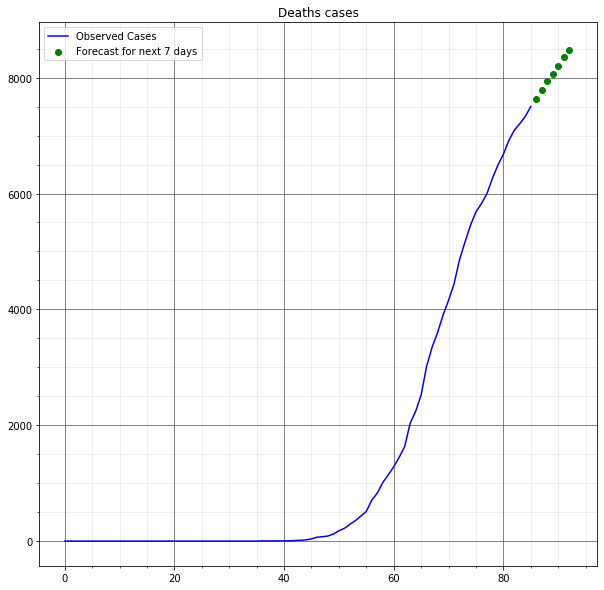

In [386]:
plot_arima(model_belgium_dea_arima,data_bel,'Deaths',1,True)

### Italy

RMSE =  1167.1808470392655
Average Percentage error (in %) =  0.5578983100654885


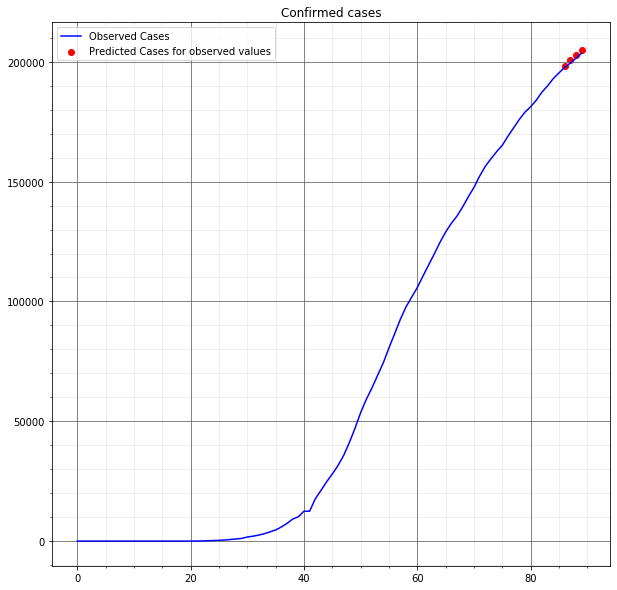

In [387]:
model_cnf = give_full_arima('Confirmed',data_italy,5,1,4)
plot_arima(model_cnf,data_italy,'Confirmed',0.96,False)

RMSE =  1701.857348164715
Average Percentage error (in %) =  2.3881905844293736


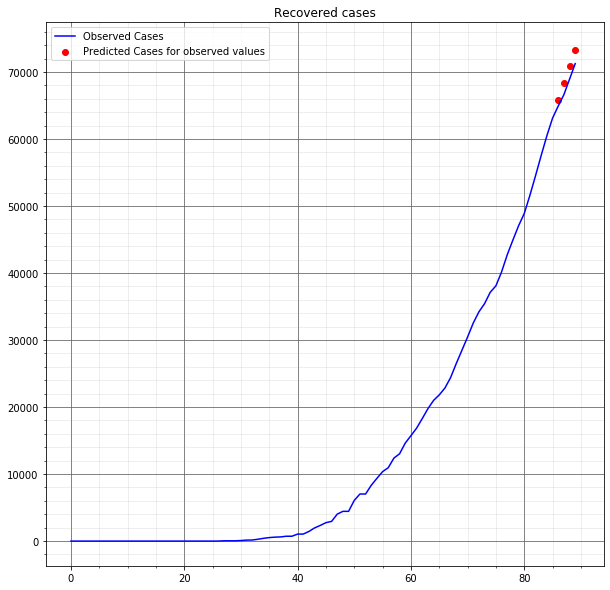

In [388]:
model_rec = give_full_arima('Recovered',data_italy,2,1,0)
plot_arima(model_rec,data_italy,'Recovered',0.96,False)

/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


RMSE =  189.50195750092865
Average Percentage error (in %) =  0.6727003818818704


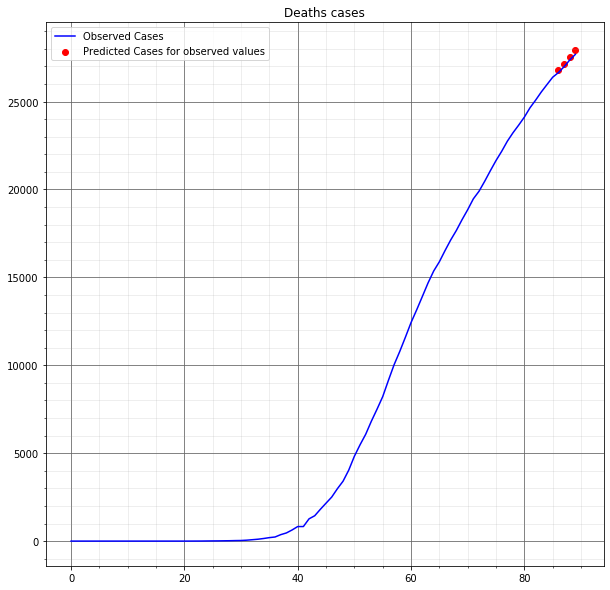

In [389]:
model_dea = give_full_arima('Deaths',data_italy,4,1,3)
plot_arima(model_dea,data_italy,'Deaths',0.96,False)

In [390]:
do_shit_arima('italy','Confirmed',data_italy,5,1,4)
do_shit_arima('italy','Recovered',data_italy,2,1,0)
do_shit_arima('italy','Deaths',data_italy,4,1,3)

/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [391]:
model_italy_cnf_arima = load_pickle('model_arima_italy_Confirmed.pkl')
model_italy_rec_arima = load_pickle('model_arima_italy_Recovered.pkl')
model_italy_dea_arima = load_pickle('model_arima_italy_Deaths.pkl')
predict("2020-04-30","2020-05-07","italy",model_italy_cnf_arima,model_italy_rec_arima,model_italy_dea_arima,data_italy,'./test_op/')

         Date      Confirmed     Recovered        Deaths
0  2020-04-30  205258.280455  73475.740964  28055.244312
1  2020-05-01  206931.928058  75644.475967  28456.572283
2  2020-05-02  208569.169255  77751.112023  28815.640814
3  2020-05-03  210322.195962  79801.934184  29157.389528
4  2020-05-04  212105.918978  81798.432166  29522.746073
5  2020-05-05  213845.926064  83743.576215  29892.290301
6  2020-05-06  215446.326560  85639.661019  30243.061754
7  2020-05-07  216910.344679  87489.057069  30589.422327


### Forecasting : Italy

[90, 91, 92, 93, 94, 95, 96]


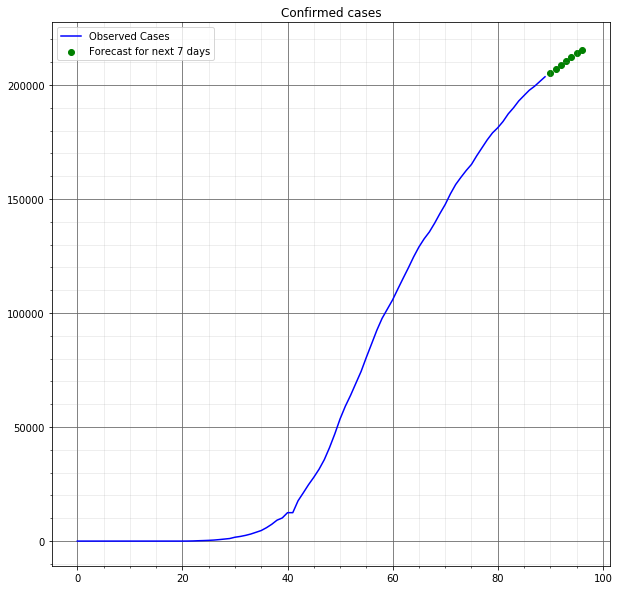

In [392]:
plot_arima(model_italy_cnf_arima,data_italy,'Confirmed',1,True)

[90, 91, 92, 93, 94, 95, 96]


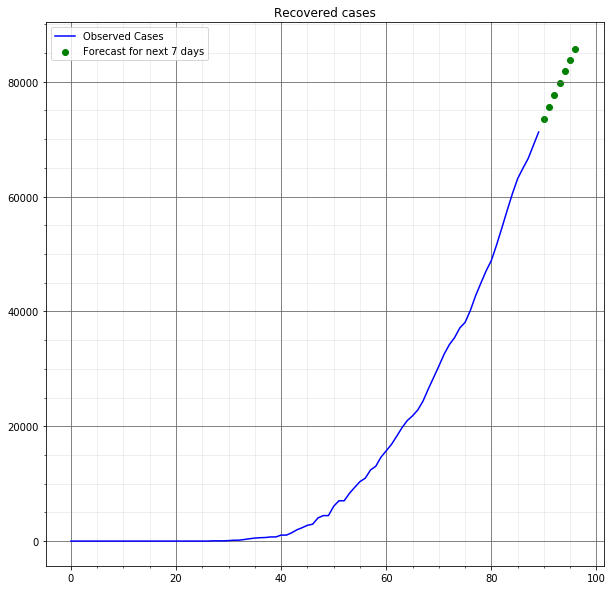

In [393]:
plot_arima(model_italy_rec_arima,data_italy,'Recovered',1,True)

[90, 91, 92, 93, 94, 95, 96]


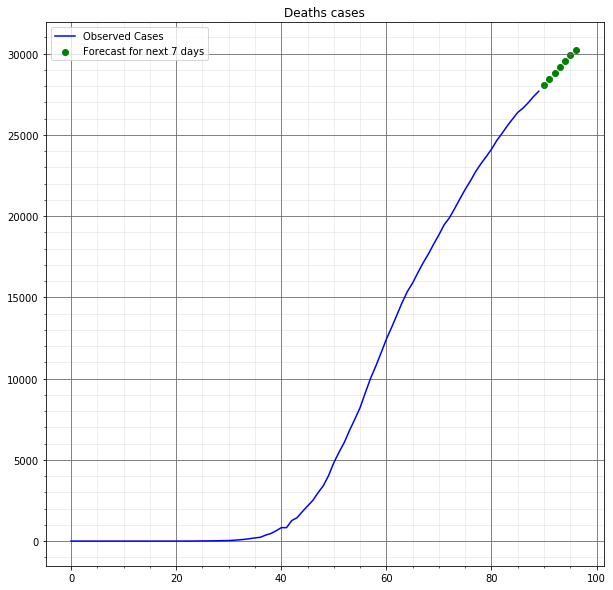

In [394]:
plot_arima(model_italy_dea_arima,data_italy,'Deaths',1,True)